In [1]:
import cProfile
import os
import pickle
import pstats
import re
import time
from collections import namedtuple, defaultdict
from typing import List
from multiprocessing import Pool
import networkx as NX
import pandas as pds
import matplotlib.pyplot as plt
import itertools
import math
import re
import statistics
from pprint import pprint

import rich.progress
import scipy
from scipy import stats as scistats
from sklearn import linear_model, preprocessing
from tabulate import tabulate
from pathlib import Path
import pickle
import random
import argparse
import sys

import data_types
from db_actions import db_actions
import numpy as np
from my_yaml import yaml_load, yaml_dump
from alive_progress import alive_bar
import seaborn as sns
from data_types import PickleOut
import commons
import rich.status
from rich.pretty import pprint
from rich import inspect


In [2]:
rc = commons.rc

In [3]:
TR = namedtuple('TableRow', ["cluster", "wfName", "method", "res"])
BigTR = namedtuple("BigTableRow", ["regModel", "cluster", "clusterSize", "wfName", "method", "res", "schedCat", "schedType"])
CVBigTR = namedtuple("CVBigTableRow", ["regModel", "cluster", "clusterSize", "wfName", "method", "res", "schedCat", "schedType", "cvSplit"])
CVUBigTR = namedtuple("CVUBigTableRow", [
    "regModel",
    "cluster",
    "clusterSize",
    "wfName",
    "method",
    "res",
    #"schedCat",
    #"schedType",
    "cvSplit",
    "ukSplit"])

In [4]:
shortToLongNameLUT = {'Linear'       : 'Ordinary Least Squares',
                      'SVR-linear'   : 'SVR - linear',
                      'SVR-poly'     : 'SVR - poly',
                      'SVR-rbf'      : 'SVR - rbf',
                      'SVR-sigmoid'  : 'SVR - sigmoid',
                      'Lasso'        : 'Lasso',
                      'LassoCV'      : 'Lasso CV',
                      'Ridge'        : 'Ridge',
                      'RidgeCV'      : 'Ridge CV',
                      'ElasticNet'   : 'Elastic Net',
                      'ElasticNetCV' : 'Elastic Net CV',
                      'BayesianRidge': 'Bayesian Ridge',
                      'ARD'          : 'Automatic Relevance Determination',
                      'SGD'          : 'Stochastic Gradient Descent',
                      'PA'           : 'Passive Aggressive',
                      'Huber'        : 'Huber',
                      'TheilSen'     : 'Theil Sen'}

In [5]:
def load_from_file(f, prog: rich.progress.Progress, barid):
    modelDegLUT = {
        'linModel' : 1,
        'quadModel': 2,
        'cubeModel': 3,
        'tetModel' : 4,
        'penModel' : 5
    }
    shorterMethodNamesLUT = {
        'randomScheduler'     : 'random',
        'recommenderScheduler': 'recommender'
    }
    pFile = Path(f)
    with open(pFile, "br") as tmp:
        pl: dict = pickle.load(tmp)
    #
    m = re.match("(?:.*/)*(.*Model)\.(.*)_CV-(.*)_U-(.*)\.recSchedTimes\.pickle", f)
    modelDeg = modelDegLUT[m.group(1)]
    modelName = shortToLongNameLUT[m.group(2)]
    shortName = f"{modelDeg} / {modelName}"
    cvSplit = m.group(3)
    if cvSplit == "None":
        cvSplit = None
    ukSplit = m.group(4)
    if ukSplit == "None":
        ukSplit = None
    # for pre, deg in modelDegLUT.items():
    #     if pre in shortName:
    #         shortName = shortName.replace(pre + ".", f"{deg}/")
    #         break
    fmt = CVUBigTR
    #
    prog.reset(barid, total=len(pl.items()))
    for clusterName, cluster in pl.items():
        for wfName, wf in cluster.items():
            wfShortName = re.match("nfcore/(.*):.*", wfName).group(1)
            for methodName, res in wf.items():
                for longN, rep in shorterMethodNamesLUT.items():
                    if longN in methodName:
                        mName = methodName.replace(longN, rep)
                        break
                rowInfo = {
                    "regModel"   : shortName,
                    "cluster"    : str(clusterName),
                    "clusterSize": len(clusterName),
                    "wfName"     : wfShortName,
                    "method"     : mName,
                    #"schedCat"   : "recommenderV1,-H1,-H2,-H3" if "V1" in mName else "recommenderV2,-H1,-H2,-H3",
                    #"schedType"  : mName,
                    "cvSplit"    : cvSplit,
                    "ukSplit"    : ukSplit
                }
                if type(res) != list:
                    rowInfo["res"] = float(res)
                    yield fmt(**rowInfo)
                # else:
                #     rowInfo["regModel"] = "N/A"
                #     rowInfo["schedCat"] = "random"
                #     rowInfo["schedType"] = "random"
                #     randomPs = [1, 2, 3]
                #     for i, r in enumerate(res):  # this only applies to the results of the randomScheduler(V1)
                #         if i + 1 in randomPs:
                #             rowInfo["method"] = mName + f"P{i * 10}"
                #             rowInfo["res"] = float(r)
                #             yield fmt(**rowInfo)
                #     rowInfo["method"] = mName + "Avg"
                #     rowInfo["res"] = float(statistics.mean(res))
                #     yield fmt(**rowInfo)
        prog.advance(barid)
    del pl


def load_random_from_files(d, prog: rich.progress.Progress, barid):
    if type(d) is str:
        d = Path(d)
    #
    refFile = d.joinpath(os.listdir(d)[0])
    with open(refFile, "br") as tmp:
        refP: dict = pickle.load(tmp)
    #
    fmt = CVUBigTR
    cls = list(refP.keys())
    wfs = list(refP[cls[0]].keys())
    del refP
    prog.reset(barid, total=len(cls) * len(wfs))
    pls = list()
    for fName in os.listdir(d):
        pFile = d.joinpath(fName)
        with open(pFile, "br") as tmp:
            pl: dict = pickle.load(tmp)
        for clusterName, cluster in pl.items():
            for wfName, wf in cluster.items():
                for methodName in list(wf.keys()):
                    if not "random" in methodName:
                        del pl[clusterName][wfName][methodName]
        #
        pls.append(pl)
        del pl
    for clusterName in cls:
        for wfName in wfs:
            wfShortName = re.match("nfcore/(.*):.*", wfName).group(1)
            #
            randoms = [x for pl in pls for x in pl[clusterName][wfName]["randomSchedulerV1"]]
            for pl in pls:
                del pl[clusterName][wfName]
            randoms.sort()
            indices = [int(round(len(randoms) - 1 - x * (len(randoms) - 1), 0)) for x in [a / 10 for a in range(0, 11)]]
            randoms = [x for i, x in enumerate(randoms) if i in indices]
            rowInfo = {
                "regModel"   : "N/A",
                "cluster"    : str(clusterName),
                "clusterSize": len(clusterName),
                "wfName"     : wfShortName,
                "method"     : "randomV1",
                #"schedCat"   : "random",
                #"schedType"  : "random",
                "cvSplit"    : "N/A",
                "ukSplit"    : "N/A"
            }
            for i, r in enumerate(randoms):  # this only applies to the results of the randomScheduler(V1)
                rowInfo["method"] = f"randomV1P{i * 10}"
                rowInfo["res"] = float(r)
                yield fmt(**rowInfo)
            rowInfo["method"] = "randomV1Avg"
            rowInfo["res"] = float(statistics.mean(randoms))
            yield fmt(**rowInfo)
            prog.advance(barid)


def load_from_dir(d):
    with commons.stdProgress(rc) as prog:
        # with alive_bar(len(os.listdir(d)), f"Loading recommenderScheduler results from {d}") as bar:
        fileProg = prog.add_task("Files", total=len(os.listdir(d)))
        clusterProg = prog.add_task("Clusters")
        for f in os.listdir(d):
            yield from load_from_file(f"{d}/{f}", prog, clusterProg)
            prog.advance(fileProg)
        randomsProg = prog.add_task("Randoms")
        yield from load_random_from_files(d, prog, randomsProg)

In [6]:
def get_bigtable(saveLoc, btFileLoc):
    btFile = Path(btFileLoc)
    if not btFile.is_file():
        bigtable = pds.DataFrame(load_from_dir(saveLoc), columns=CVUBigTR._fields)
        with open(btFile, "bw") as f:
            pickle.dump(bigtable, f)
    else:
        with open(btFile, "br") as f:
            bigtable = pickle.load(f)
    return bigtable

In [7]:
def save_plot(obj, name, loc="./fig/", **kwargs):
    obj.savefig(f"{loc}{name}.pdf", transparent=True, **kwargs)
    obj.savefig(f"{loc}{name}.png", transparent=True, **kwargs)

# Get the recSchedTimes data

In [8]:
bigtable = get_bigtable("recSchedTimes", "./recSchedBigTable.pickle")  #.sample(frac=5 / 100, random_state=0, axis=0)
# bigtable

# Get the cvRecSchedTimes data

In [9]:
cvBigtable = get_bigtable("cvRecSchedTimes", "./cvRecSchedBigTable.pickle")  #.sample(frac=5 / 100, random_state=0, axis=0)
# cvBigtable

In [10]:
wfNames = bigtable.wfName.unique()

In [11]:
sns.set_theme(style="whitegrid")
#sns.set_context("paper")
sns.set_context("paper", 1.65)

In [12]:
pds.set_option('display.max_rows', 100)
pds.set_option('display.max_columns', None)
pds.set_option('display.width', None)
pds.set_option('display.precision', 4)


# trying out new visualisation

In [13]:
def getRegModelMethodScores(fileLoc: Path, table, crit=None, scorer=None, tol=1):
    if crit is None:
        def yep (cur, mini, tol): 
            return abs(cur-mini)<=tol
        crit = yep
    if scorer is None:
        def sc(cur, mini, tol):
            return 1
        scorer = sc
    if type(fileLoc) is str:
        fileLoc = Path(fileLoc)
    if fileLoc.is_file():
        with open(fileLoc, "br") as f:
            return pickle.load(f)
    else:
        grouped = table[table.regModel != "N/A"].pivot(["cluster", "wfName", "regModel"], "method", "res")
        clWFCombs = itertools.product(clusters, wfNames)
        numclWFCombs = len(list(clWFCombs))
        clWFCombs = itertools.product(clusters, wfNames)
        rMMethCombs = list(itertools.product(regModels, methods))
        # regModelMethodScores = defaultdict(lambda: 0)
        with commons.stdProgress(rc) as prog:
            cvwfProg = prog.add_task("Cluster/Workflow", total=numclWFCombs)
            regModelMethodScores = defaultdict(lambda: 0)

            for clwf, subtable in grouped.groupby(level=(0, 1), group_keys=False):
                c, wf = clwf
                subtable = subtable.droplevel(["cluster", "wfName"])
                minimumTime = subtable.min().min()
                for rmmetch in rMMethCombs:
                    rM, meth = rmmetch
                    # rc.log(subtable.loc[rM, meth], minimumTime, abs(subtable.loc[rM, meth] - minimumTime), abs(subtable.loc[rM, meth] - minimumTime) <= tol)
                    curr= subtable.loc[rM, meth]
                    if type(tol) is int or type(tol) is float:
                        t= tol
                    else:
                        t = tol(curr, minimumTime)
                    if crit(curr, minimumTime, t):
                        regModelMethodScores[rmmetch] = regModelMethodScores[rmmetch] + scorer(curr, minimumTime, t)
                prog.advance(cvwfProg)
            regModelMethodScores = dict(regModelMethodScores)
        #
        with open(fileLoc, "bw") as f:
            pickle.dump(regModelMethodScores, f)
        return dict(regModelMethodScores)

------

In [14]:
tmp = bigtable[bigtable.regModel != "N/A"]
clusters = tmp.cluster.unique()
regModels = tmp.regModel.unique()
methods = tmp.method.unique()
del tmp

In [15]:
confs = dict()
with open("percentileModels","r") as f:
    for fName in f:
        with open(fName.strip(), "br") as f2:
            l:PickleOut = pickle.load(f2)
            m = re.match("(?:.*/)*(.*)\.(.*)_CV-(.*)_U-(.*).pickle",fName.strip())
            confs[f"{l.polyDeg} / {shortToLongNameLUT[m.group(2)]}"] = commons.jamGeomean([l.train_confidence, l.test_confidence, l.full_confidence])
            

In [16]:
confs

{
│   '5 / Ordinary Least Squares': 1.0,
│   '3 / Ridge': 0.9231538458419148,
│   ... +9
}

In [17]:
regModels = sorted(regModels, key=lambda x: confs[x], reverse=True)

In [18]:
pprint(regModels)

[
│   '5 / Ordinary Least Squares',
│   '3 / Ridge',
│   '3 / SVR - linear',
│   '3 / Elastic Net CV',
│   '2 / Ridge CV',
│   '1 / Ordinary Least Squares',
│   '1 / Lasso CV',
│   '1 / SVR - linear',
│   '3 / Elastic Net',
│   '1 / Elastic Net',
│   '4 / Passive Aggressive'
]

In [19]:
regModelMethodScores = getRegModelMethodScores("regModelMethodScores.pickle", bigtable)

In [20]:
regModelMethodScores10P  = getRegModelMethodScores("regModelMethodScores10P.pickle", bigtable, tol=lambda cur, mini: 10*mini/100)

In [21]:
regModelMethodScores

{
│   ('1 / Lasso CV', 'recommenderV1'): 5346,
│   ('1 / Lasso CV', 'recommenderV1H1'): 5516,
│   ... +86
}

In [22]:
regModelMethodScores10P

{
│   ('1 / Lasso CV', 'recommenderV1'): 35744,
│   ('1 / Lasso CV', 'recommenderV1H1'): 35850,
│   ... +86
}

In [23]:
regModelMethodScoresDF = pds.DataFrame(index=regModels, columns=methods, dtype=float)
for rm, s in regModelMethodScores.items():
    rM, meth = rm
    regModelMethodScoresDF.loc[rM, meth] = s

In [24]:
regModelMethodScoresDF

,recommenderV1,recommenderV1H1,recommenderV1H2,recommenderV1H3,recommenderV2,recommenderV2H1,recommenderV2H2,recommenderV2H3
5 / Ordinary Least Squares,25731.0,27353.0,27353.0,28508.0,9615.0,9903.0,9903.0,9654.0
3 / Ridge,9628.0,10563.0,10563.0,11010.0,6874.0,6824.0,6824.0,6643.0
3 / SVR - linear,5818.0,6311.0,6311.0,6909.0,5492.0,5875.0,5875.0,5797.0
3 / Elastic Net CV,7031.0,6694.0,6694.0,6641.0,5087.0,5512.0,5512.0,5272.0
2 / Ridge CV,5328.0,5502.0,5502.0,5439.0,5277.0,5668.0,5668.0,5445.0
1 / Ordinary Least Squares,5369.0,5422.0,5422.0,5116.0,4605.0,5089.0,5089.0,4854.0
1 / Lasso CV,5346.0,5516.0,5516.0,5329.0,4467.0,4961.0,4961.0,4766.0
1 / SVR - linear,4731.0,5343.0,5343.0,5141.0,4179.0,4546.0,4546.0,4344.0
3 / Elastic Net,5347.0,4954.0,4954.0,4851.0,3742.0,4000.0,4000.0,3851.0
1 / Elastic Net,3789.0,4030.0,4030.0,4232.0,2613.0,2895.0,2895.0,2833.0


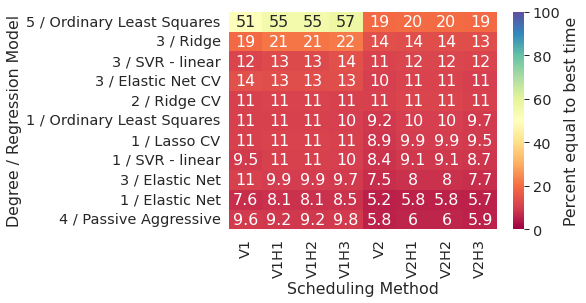

In [25]:
# normalize
total = 50_000
tmp = regModelMethodScoresDF.transform(lambda x: 100*x/total)
#
ax = sns.heatmap(tmp,
                 cmap="Spectral",
                 xticklabels=[c.replace("recommender", "") for c in regModelMethodScoresDF.columns],
                 cbar_kws={"label":"Percent equal to best time"},
                 vmin=0,
                 vmax=100,
                 annot=True,
                 robust=True)
plt.xlabel("Scheduling Method")
plt.ylabel("Degree / Regression Model")
fig = ax.get_figure()
save_plot(fig, "heatmapBIS", bbox_inches="tight")
plt.show()

In [26]:
regModelMethodScores10PDF = pds.DataFrame(index=regModels, columns=methods, dtype=float)
for rm, s in regModelMethodScores10P.items():
    rM, meth = rm
    regModelMethodScores10PDF.loc[rM, meth] = s

In [27]:
regModelMethodScores10PDF

,recommenderV1,recommenderV1H1,recommenderV1H2,recommenderV1H3,recommenderV2,recommenderV2H1,recommenderV2H2,recommenderV2H3
5 / Ordinary Least Squares,43509.0,43304.0,43304.0,44438.0,37449.0,36687.0,36687.0,36050.0
3 / Ridge,42956.0,42587.0,42587.0,43463.0,37101.0,35902.0,35902.0,34888.0
3 / SVR - linear,38292.0,39259.0,39259.0,40567.0,35636.0,34450.0,34450.0,33553.0
3 / Elastic Net CV,38136.0,38746.0,38746.0,39246.0,34599.0,34365.0,34365.0,32863.0
2 / Ridge CV,37002.0,38431.0,38431.0,38518.0,35209.0,35127.0,35127.0,33285.0
1 / Ordinary Least Squares,33601.0,34683.0,34683.0,34709.0,33180.0,33224.0,33224.0,31051.0
1 / Lasso CV,35744.0,35850.0,35850.0,35905.0,32357.0,32831.0,32831.0,30720.0
1 / SVR - linear,33344.0,34826.0,34826.0,34813.0,32533.0,32668.0,32668.0,30441.0
3 / Elastic Net,34241.0,33357.0,33357.0,33455.0,30570.0,29937.0,29937.0,27852.0
1 / Elastic Net,30086.0,30887.0,30887.0,30790.0,27218.0,26728.0,26728.0,25694.0


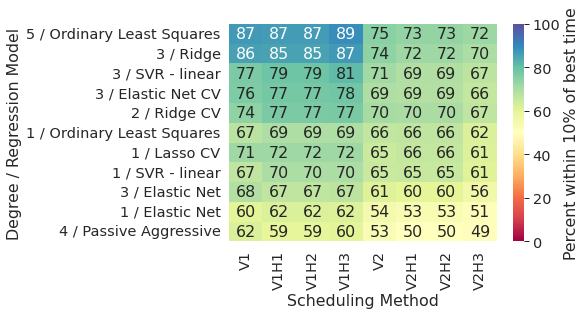

In [28]:
# normalize
total = 50_000
tmp = regModelMethodScores10PDF.transform(lambda x: 100*x/total)
#
ax = sns.heatmap(tmp,
                 cmap="Spectral",
                 xticklabels=[c.replace("recommender", "") for c in regModelMethodScores10PDF.columns],
                 cbar_kws={"label":"Percent within 10% of best time"},
                 vmin=0,
                 vmax=100,
                 annot=True,
                 robust=True)
plt.xlabel("Scheduling Method")
plt.ylabel("Degree / Regression Model")
fig = ax.get_figure()
save_plot(fig, "heatmap10P", bbox_inches="tight")
plt.show()

------

In [29]:
tmp = cvBigtable[cvBigtable.regModel != "N/A"]
clusters = tmp.cluster.unique()
regModels = tmp.regModel.unique()
methods = tmp.method.unique()
del tmp

In [30]:
confs = dict()
with open("percentileCVModels","r") as f:
    for fName in f:
        with open(fName.strip(), "br") as f2:
            l:PickleOut = pickle.load(f2)
            m = re.match("(?:.*/)*(.*)\.(.*)_CV-(.*)_U-(.*).pickle",fName.strip())
            key = f"{l.polyDeg} / {shortToLongNameLUT[m.group(2)]}"
            p  = confs.get(key, list())
            confs[key] = p + [commons.jamGeomean([l.train_confidence, l.test_confidence, l.full_confidence])]
for k, l in confs.items():
    confs[k] = commons.jamGeomean(l)
            

In [31]:
pprint(confs)

{
│   '1 / SVR - rbf': 0.8387889322997693,
│   '1 / Stochastic Gradient Descent': 0.7855591233166146,
│   '3 / SVR - rbf': 0.46743515455075557
}

In [32]:
regModels = sorted(regModels, key=lambda x: confs[x], reverse=True)

In [33]:
pprint(regModels)

['1 / SVR - rbf', '1 / Stochastic Gradient Descent', '3 / SVR - rbf']

In [34]:
cvScores = dict()
cv10PScores = dict()
j = 1
for i, d in cvBigtable[cvBigtable.regModel != "N/A"].groupby(["cvSplit","ukSplit"]):
    rc.log(j, i)
    cvScores[i] = getRegModelMethodScores(f"cvRegModelMethodScores_CV-{i[0]}_U-{i[1]}.pickle", d.drop(["cvSplit","ukSplit"], axis=1))
    cv10PScores[i] = getRegModelMethodScores(f"cvRegModelMethodScores10P_CV-{i[0]}_U-{i[1]}.pickle", d.drop(["cvSplit","ukSplit"], axis=1), tol=lambda cur, mini: 10*mini/100)
    j+=1

[23:24:20] 1                                                                  ]8;id=820259;file:///tmp/ipykernel_37830/4193304240.py\4193304240.py]8;;\:5
           ('chipseq', 'eager')

           2                                                                  ]8;id=167393;file:///tmp/ipykernel_37830/4193304240.py\4193304240.py]8;;\:5
           ('chipseq', 'methylseq')

           3                                                                  ]8;id=846986;file:///tmp/ipykernel_37830/4193304240.py\4193304240.py]8;;\:5
           ('chipseq', 'sarek')

           4                                                                  ]8;id=457421;file:///tmp/ipykernel_37830/4193304240.py\4193304240.py]8;;\:5
           ('chipseq', 'viralrecon')

           5                                                                  ]8;id=31774;file:///tmp/ipykernel_37830/4193304240.py\4193304240.py]8;;\:5
           ('eager', 'chipseq')

           6                                                                  ]8;id=23878;file:///tmp/ipykernel_37830/4193304240.py\4193304240.py]8;;\:5
           ('eager', 'methylseq')

[23:24:21] 7                                                                  ]8;id=267148;file:///tmp/ipykernel_37830/4193304240.py\4193304240.py]8;;\:5
           ('eager', 'sarek')

           8                                                                  ]8;id=138296;file:///tmp/ipykernel_37830/4193304240.py\4193304240.py]8;;\:5
           ('eager', 'viralrecon')

           9                                                                  ]8;id=386783;file:///tmp/ipykernel_37830/4193304240.py\4193304240.py]8;;\:5
           ('methylseq', 'chipseq')

           10                                                                 ]8;id=263608;file:///tmp/ipykernel_37830/4193304240.py\4193304240.py]8;;\:5
           ('methylseq', 'eager')

           11                                                                 ]8;id=308940;file:///tmp/ipykernel_37830/4193304240.py\4193304240.py]8;;\:5
           ('methylseq', 'sarek')

           12                                                                 ]8;id=182178;file:///tmp/ipykernel_37830/4193304240.py\4193304240.py]8;;\:5
           ('methylseq', 'viralrecon')

           13                                                                 ]8;id=959651;file:///tmp/ipykernel_37830/4193304240.py\4193304240.py]8;;\:5
           ('sarek', 'chipseq')

           14                                                                 ]8;id=773798;file:///tmp/ipykernel_37830/4193304240.py\4193304240.py]8;;\:5
           ('sarek', 'eager')

[23:24:22] 15                                                                 ]8;id=432311;file:///tmp/ipykernel_37830/4193304240.py\4193304240.py]8;;\:5
           ('sarek', 'methylseq')

           16                                                                 ]8;id=949193;file:///tmp/ipykernel_37830/4193304240.py\4193304240.py]8;;\:5
           ('sarek', 'viralrecon')

           17                                                                 ]8;id=438397;file:///tmp/ipykernel_37830/4193304240.py\4193304240.py]8;;\:5
           ('viralrecon', 'chipseq')

           18                                                                 ]8;id=116070;file:///tmp/ipykernel_37830/4193304240.py\4193304240.py]8;;\:5
           ('viralrecon', 'eager')

           19                                                                 ]8;id=591299;file:///tmp/ipykernel_37830/4193304240.py\4193304240.py]8;;\:5
           ('viralrecon', 'methylseq')

           20                                                                 ]8;id=978798;file:///tmp/ipykernel_37830/4193304240.py\4193304240.py]8;;\:5
           ('viralrecon', 'sarek')

In [35]:
cvScores

{
│   ('chipseq', 'eager'): {
│   │   ('1 / SVR - rbf', 'recommenderV1'): 19175,
│   │   ('1 / SVR - rbf', 'recommenderV1H1'): 19638,
│   │   ... +22
│   },
│   ('chipseq', 'methylseq'): {
│   │   ('1 / SVR - rbf', 'recommenderV1'): 12151,
│   │   ('1 / SVR - rbf', 'recommenderV1H1'): 13657,
│   │   ... +22
│   },
│   ... +18
}

In [36]:
cv10PScores

{
│   ('chipseq', 'eager'): {
│   │   ('1 / SVR - rbf', 'recommenderV1'): 38578,
│   │   ('1 / SVR - rbf', 'recommenderV1H1'): 39227,
│   │   ... +22
│   },
│   ('chipseq', 'methylseq'): {
│   │   ('1 / SVR - rbf', 'recommenderV1'): 39139,
│   │   ('1 / SVR - rbf', 'recommenderV1H1'): 39904,
│   │   ... +22
│   },
│   ... +18
}

In [37]:
cvRegModelMethodScores = dict()
for _, sc in cvScores.items():
    for rmmeth, r in sc.items():
        cvRegModelMethodScores[rmmeth] = cvRegModelMethodScores.get(rmmeth,0)+r

In [38]:
cvRegModelMethodScores10P = dict()
for _, sc in cv10PScores.items():
    for rmmeth, r in sc.items():
        cvRegModelMethodScores10P[rmmeth] = cvRegModelMethodScores10P.get(rmmeth,0)+r

In [39]:
cvRegModelMethodScores

{
│   ('1 / SVR - rbf', 'recommenderV1'): 259713,
│   ('1 / SVR - rbf', 'recommenderV1H1'): 275020,
│   ... +22
}

In [40]:
cvRegModelMethodScores10P

{
│   ('1 / SVR - rbf', 'recommenderV1'): 759588,
│   ('1 / SVR - rbf', 'recommenderV1H1'): 765871,
│   ... +22
}

In [41]:
cvRegModelMethodScoresDF = pds.DataFrame(index=regModels, columns=methods, dtype=float)
for rm, s in cvRegModelMethodScores.items():
    rM, meth = rm
    cvRegModelMethodScoresDF.loc[rM, meth] = s

In [42]:
cvRegModelMethodScoresDF

,recommenderV1,recommenderV1H1,recommenderV1H2,recommenderV1H3,recommenderV2,recommenderV2H1,recommenderV2H2,recommenderV2H3
1 / SVR - rbf,259713.0,275020.0,275020.0,290446.0,198989.0,218629.0,218629.0,205442.0
1 / Stochastic Gradient Descent,197793.0,199337.0,199337.0,197955.0,170579.0,186399.0,186399.0,175455.0
3 / SVR - rbf,197748.0,196185.0,196185.0,208983.0,111865.0,120898.0,120898.0,117597.0


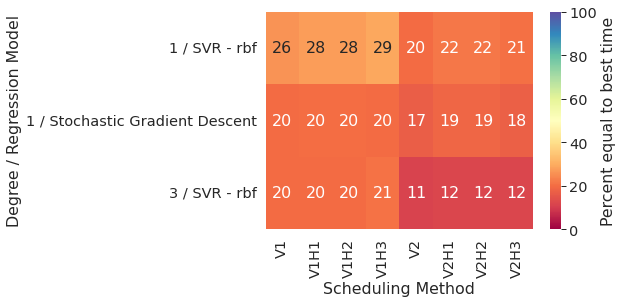

In [43]:
# normalize
total = 20*50_000
tmp = cvRegModelMethodScoresDF.transform(lambda x: 100*x/total)
#
ax = sns.heatmap(tmp,
                 cmap="Spectral",
                 xticklabels=[c.replace("recommender", "") for c in cvRegModelMethodScoresDF.columns],
                 cbar_kws={"label":"Percent equal to best time"},
                 vmin=0,
                 vmax=100,
                 annot=True,
                 robust=True)
plt.xlabel("Scheduling Method")
plt.ylabel("Degree / Regression Model")
fig = ax.get_figure()
save_plot(fig, "cvHeatmapBIS", bbox_inches="tight")
plt.show()

In [44]:
cvRegModelMethodScores10PDF = pds.DataFrame(index=regModels, columns=methods, dtype=float)
for rm, s in cvRegModelMethodScores10P.items():
    rM, meth = rm
    cvRegModelMethodScores10PDF.loc[rM, meth] = s

In [45]:
cvRegModelMethodScores10PDF

,recommenderV1,recommenderV1H1,recommenderV1H2,recommenderV1H3,recommenderV2,recommenderV2H1,recommenderV2H2,recommenderV2H3
1 / SVR - rbf,759588.0,765871.0,765871.0,778016.0,687719.0,683672.0,683672.0,646950.0
1 / Stochastic Gradient Descent,708525.0,722652.0,722652.0,724040.0,656117.0,677033.0,677033.0,631148.0
3 / SVR - rbf,656111.0,650994.0,650994.0,658911.0,550538.0,529632.0,529632.0,516272.0


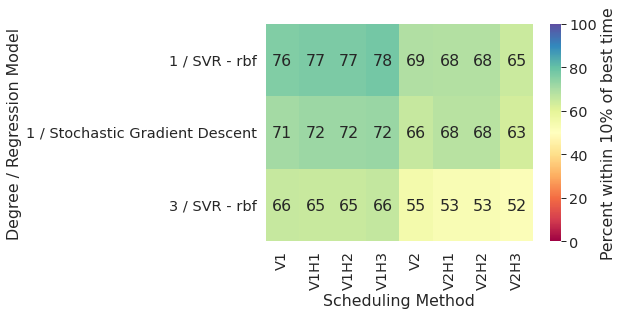

In [46]:
# normalize
total = 20*50_000
tmp = cvRegModelMethodScores10PDF.transform(lambda x: 100*x/total)
#
ax = sns.heatmap(tmp,
                 cmap="Spectral",
                 xticklabels=[c.replace("recommender", "") for c in cvRegModelMethodScores10PDF.columns],
                 cbar_kws={"label":"Percent within 10% of best time"},
                 vmin=0,
                 vmax=100,
                 annot=True,
                 robust=True)
plt.xlabel("Scheduling Method")
plt.ylabel("Degree / Regression Model")
fig = ax.get_figure()
save_plot(fig, "heatmap10P", bbox_inches="tight")
plt.show()

------

In [47]:
def compareCVFull(fullTable, cvSplitTable, crit=None, scorer=None, tol=1):
    if crit is None:
        def yep (res, cvres, tol): 
            dist = abs(res-cvres)
            if dist <=tol:
                dec  =0
            elif res < cvres:
                dec = -1
            else:
                dec = 1
            return dec
        crit = yep
    if scorer is None:
        def sc(res, cvres, tol):
            return 1
        scorer = sc
    #
    totalTable = fullTable.join(cvSplitTable.set_index(["cluster", "wfName"]), on=["cluster", "wfName"], rsuffix="_cv")
    #
    clWFCombs = itertools.product(clusters, wfNames)
    numclWFCombs = len(list(clWFCombs))
    #
    comp = dict(full=0, equal=0, cv=0)
    with commons.stdProgress(rc) as prog:
        cvwfProg = prog.add_task("Comparing", total=numclWFCombs)

        for row in totalTable.itertuples():
            if type(tol) is int or type(tol) is float:
                t= tol
            else:
                t = tol(row.res, row.res_cv)
            dec = crit(row.res, row.res_cv, t)
            if dec ==-1:
                key = "full"
            elif dec == 0:
                key= "equal"
            elif dec == 1:
                key = "cv"
            else:
                raise Exception("crit must return -1, 0, or 1")

            comp[key] = comp[key] + scorer(row.res, row.res_cv, t)
            prog.advance(cvwfProg)
    return comp

In [48]:
maxi = regModelMethodScoresDF.max().max()
cand = regModelMethodScoresDF.idxmax().reset_index()
cand.columns=["method","model"]
bisRmmeth = None
for i in cand.itertuples():
    if regModelMethodScoresDF.loc[i.model, i.method]==maxi:
        bisRmmeth = (i.model, i.method)
        break
bisRmmeth

(
│   '5 / Ordinary Least Squares',
│   'recommenderV1H3'
)

In [55]:
if Path("bisBigtable.pickle").is_file():
    with open("bisBigtable.pickle", "br") as f:
        bisBigtable = pickle.load(f)
else:
    bisBigtable = bigtable.query("regModel==@bisRmmeth[0] and method==@bisRmmeth[1]")
    #bisBigtable.drop(["regModel", "method", "cvSplit", "ukSplit", "clusterSize"], axis=1)
    with open("bisBigtable.pickle", "bw") as f:
        bisBigtable = pickle.dump(bisBigtable,f)
bisBigtable

ERROR! Session/line number was not unique in database. History logging moved to new session 16


,regModel,cluster,clusterSize,wfName,method,res,cvSplit,ukSplit
400003,5 / Ordinary Least Squares,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,sarek,recommenderV1H3,33364.6500,None,None
400011,5 / Ordinary Least Squares,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,methylseq,recommenderV1H3,39318.6000,None,None
400019,5 / Ordinary Least Squares,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,chipseq,recommenderV1H3,126638.2667,None,None
400027,5 / Ordinary Least Squares,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,eager,recommenderV1H3,27151.2000,None,None
400035,5 / Ordinary Least Squares,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,viralrecon,recommenderV1H3,138079.2667,None,None
...,...,...,...,...,...,...,...,...
799963,5 / Ordinary Least Squares,"(165, 166, 169, 170, 173, 173, 175, 176, 178, ...",20,sarek,recommenderV1H3,33356.3500,None,None
799971,5 / Ordinary Least Squares,"(165, 166, 169, 170, 173, 173, 175, 176, 178, ...",20,methylseq,recommenderV1H3,39318.6000,None,None
799979,5 / Ordinary Least Squares,"(165, 166, 169, 170, 173, 173, 175, 176, 178, ...",20,chipseq,recommenderV1H3,126735.6333,None,None
799987,5 / Ordinary Least Squares,"(165, 166, 169, 170, 173, 173, 175, 176, 178, ...",20,eager,recommenderV1H3,27574.6000,None,None


In [50]:
maxi = cvRegModelMethodScoresDF.max().max()
cand = cvRegModelMethodScoresDF.idxmax().reset_index()
cand.columns=["method","model"]
bisCVRmmeth = None
for i in cand.itertuples():
    if cvRegModelMethodScoresDF.loc[i.model, i.method]==maxi:
        bisCVRmmeth = (i.model, i.method)
        break
bisCVRmmeth

(
│   '1 / SVR - rbf',
│   'recommenderV1H3'
)

In [56]:
if Path("bisCVBigtable.pickle").is_file():
    with open("bisCVBigtable.pickle", "br") as f:
        bisCVBigtable = pickle.load(f)
else:
    bisCVBigtable = cvBigtable.query("regModel==@bisCVRmmeth[0] and method==@bisCVRmmeth[1]")
    #bisCVBigtable.drop(["regModel", "method", "clusterSize"], axis=1)
    with open("bisCVBigtable.pickle", "bw") as f:
        pickle.dump(bisCVBigtable, f)
bis

In [52]:
if Path("splitComp.pickle").is_file():
    with open("splitComp.pickle", "br") as f:
        splitComp = pickle.load(f)
else:
    splitComp = dict()
    for split, tab in bisCVBigtable.groupby(["cvSplit", "ukSplit"]):
        rc.log(split)
        splitComp[split] = compareCVFull(bisBigtable, tab.drop(["cvSplit", "ukSplit"],axis=1))
        rc.log(splitComp[split])
    with open("splitComp.pickle", "bw") as f:
        pickle.dump(splitComp, f)
pprint(splitComp)

{
│   ('chipseq', 'eager'): {'full': 29475, 'equal': 15932, 'cv': 4593},
│   ('chipseq', 'methylseq'): {'full': 32719, 'equal': 13238, 'cv': 4043},
│   ('chipseq', 'sarek'): {'full': 33699, 'equal': 13000, 'cv': 3301},
│   ('chipseq', 'viralrecon'): {'full': 33418, 'equal': 13427, 'cv': 3155},
│   ('eager', 'chipseq'): {'full': 36824, 'equal': 9774, 'cv': 3402},
│   ('eager', 'methylseq'): {'full': 36469, 'equal': 10418, 'cv': 3113},
│   ('eager', 'sarek'): {'full': 38179, 'equal': 8526, 'cv': 3295},
│   ('eager', 'viralrecon'): {'full': 32383, 'equal': 13491, 'cv': 4126},
│   ('methylseq', 'chipseq'): {'full': 33501, 'equal': 12751, 'cv': 3748},
│   ('methylseq', 'eager'): {'full': 34859, 'equal': 11823, 'cv': 3318},
│   ('methylseq', 'sarek'): {'full': 36094, 'equal': 10595, 'cv': 3311},
│   ('methylseq', 'viralrecon'): {'full': 31377, 'equal': 15532, 'cv': 3091},
│   ('sarek', 'chipseq'): {'full': 37751, 'equal': 8626, 'cv': 3623},
│   ('sarek', 'eager'): {'full': 37251, 'equal': 9476, 'cv': 3273},
│   ('sarek', 'methylseq'): {'full': 36114, 'equal': 9741, 'cv': 4145},
│   ('sarek', 'viralrecon'): {'full': 35965, 'equal': 11397, 'cv': 2638},
│   ('viralrecon', 'chipseq'): {'full': 32140, 'equal': 14288, 'cv': 3572},
│   ('viralrecon', 'eager'): {'full': 36631, 'equal': 10288, 'cv': 3081},
│   ('viralrecon', 'methylseq'): {'full': 36264, 'equal': 9845, 'cv': 3891},
│   ('viralrecon', 'sarek'): {'full': 36442, 'equal': 9829, 'cv': 3729}
}

In [53]:
col = list()
for split, comp in splitComp.items():
    cv, uk = split
    col.append([cv, uk, comp['full'], comp['equal'], comp['cv']])
compDF = pds.DataFrame(data=col, columns=["cvSplit", "ukSplit", "full", "equal", "cv"])
compDF
compDF.pivot("cvSplit", "ukSplit", "full")
#print(compDF.pivot("cvSplit", "ukSplit","text").to_latex(na_rep="-"))

ukSplit,chipseq,eager,methylseq,sarek,viralrecon
cvSplit,,,,,
chipseq,NaN,29475.0,32719.0,33699.0,33418.0
eager,36824.0,NaN,36469.0,38179.0,32383.0
methylseq,33501.0,34859.0,NaN,36094.0,31377.0
sarek,37751.0,37251.0,36114.0,NaN,35965.0
viralrecon,32140.0,36631.0,36264.0,36442.0,NaN


In [54]:
split10PComp = dict()
for split, tab in bisCVBigtable.groupby(["cvSplit", "ukSplit"]):
    rc.log(split)
    split10PComp[split] = compareCVFull(bisBigtable, tab.drop(["cvSplit", "ukSplit"],axis=1), tol=lambda res, cvres: min(res,cvres)*10/100)
    rc.log(split10PComp[split])
pprint(split10PComp)

[23:24:28] ('chipseq', 'eager')                                               ]8;id=5640;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:3

Output()

           {'full': 5307, 'equal': 44358, 'cv': 335}                          ]8;id=272974;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:5

           ('chipseq', 'methylseq')                                           ]8;id=346567;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:3

Output()

[23:24:29] {'full': 4480, 'equal': 45349, 'cv': 171}                          ]8;id=775148;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:5

           ('chipseq', 'sarek')                                               ]8;id=769800;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:3

Output()

           {'full': 4943, 'equal': 44865, 'cv': 192}                          ]8;id=922873;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:5

           ('chipseq', 'viralrecon')                                          ]8;id=646519;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:3

Output()

           {'full': 8774, 'equal': 41022, 'cv': 204}                          ]8;id=611572;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:5

           ('eager', 'chipseq')                                               ]8;id=647385;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:3

Output()

[23:24:30] {'full': 8046, 'equal': 41784, 'cv': 170}                          ]8;id=482562;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:5

           ('eager', 'methylseq')                                             ]8;id=965778;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:3

Output()

           {'full': 5734, 'equal': 44209, 'cv': 57}                           ]8;id=747938;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:5

           ('eager', 'sarek')                                                 ]8;id=395530;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:3

Output()

           {'full': 9686, 'equal': 40166, 'cv': 148}                          ]8;id=26795;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:5

           ('eager', 'viralrecon')                                            ]8;id=401758;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:3

Output()

[23:24:31] {'full': 2532, 'equal': 47368, 'cv': 100}                          ]8;id=317649;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:5

           ('methylseq', 'chipseq')                                           ]8;id=834092;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:3

Output()

           {'full': 5199, 'equal': 44519, 'cv': 282}                          ]8;id=961900;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:5

           ('methylseq', 'eager')                                             ]8;id=306426;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:3

Output()

           {'full': 4441, 'equal': 45437, 'cv': 122}                          ]8;id=159849;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:5

           ('methylseq', 'sarek')                                             ]8;id=989131;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:3

Output()

[23:24:32] {'full': 8217, 'equal': 41663, 'cv': 120}                          ]8;id=257204;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:5

           ('methylseq', 'viralrecon')                                        ]8;id=126476;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:3

Output()

           {'full': 1855, 'equal': 47807, 'cv': 338}                          ]8;id=11952;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:5

           ('sarek', 'chipseq')                                               ]8;id=146693;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:3

Output()

           {'full': 10209, 'equal': 39629, 'cv': 162}                         ]8;id=641128;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:5

           ('sarek', 'eager')                                                 ]8;id=917561;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:3

Output()

           {'full': 7398, 'equal': 42450, 'cv': 152}                          ]8;id=988394;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:5

[23:24:33] ('sarek', 'methylseq')                                             ]8;id=512407;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:3

Output()

           {'full': 10990, 'equal': 38890, 'cv': 120}                         ]8;id=211945;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:5

           ('sarek', 'viralrecon')                                            ]8;id=707763;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:3

Output()

           {'full': 7616, 'equal': 42025, 'cv': 359}                          ]8;id=26144;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:5

           ('viralrecon', 'chipseq')                                          ]8;id=233182;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:3

Output()

           {'full': 7265, 'equal': 42451, 'cv': 284}                          ]8;id=77897;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:5

           ('viralrecon', 'eager')                                            ]8;id=732450;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:3

Output()

[23:24:34] {'full': 5313, 'equal': 44513, 'cv': 174}                          ]8;id=70659;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:5

           ('viralrecon', 'methylseq')                                        ]8;id=977847;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:3

Output()

           {'full': 8457, 'equal': 41025, 'cv': 518}                          ]8;id=920115;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:5

           ('viralrecon', 'sarek')                                            ]8;id=363924;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:3

Output()

           {'full': 6373, 'equal': 43436, 'cv': 191}                          ]8;id=497798;file:///tmp/ipykernel_37830/2767032462.py\2767032462.py]8;;\:5

{
│   ('chipseq', 'eager'): {'full': 5307, 'equal': 44358, 'cv': 335},
│   ('chipseq', 'methylseq'): {'full': 4480, 'equal': 45349, 'cv': 171},
│   ('chipseq', 'sarek'): {'full': 4943, 'equal': 44865, 'cv': 192},
│   ('chipseq', 'viralrecon'): {'full': 8774, 'equal': 41022, 'cv': 204},
│   ('eager', 'chipseq'): {'full': 8046, 'equal': 41784, 'cv': 170},
│   ('eager', 'methylseq'): {'full': 5734, 'equal': 44209, 'cv': 57},
│   ('eager', 'sarek'): {'full': 9686, 'equal': 40166, 'cv': 148},
│   ('eager', 'viralrecon'): {'full': 2532, 'equal': 47368, 'cv': 100},
│   ('methylseq', 'chipseq'): {'full': 5199, 'equal': 44519, 'cv': 282},
│   ('methylseq', 'eager'): {'full': 4441, 'equal': 45437, 'cv': 122},
│   ('methylseq', 'sarek'): {'full': 8217, 'equal': 41663, 'cv': 120},
│   ('methylseq', 'viralrecon'): {'full': 1855, 'equal': 47807, 'cv': 338},
│   ('sarek', 'chipseq'): {'full': 10209, 'equal': 39629, 'cv': 162},
│   ('sarek', 'eager'): {'full': 7398, 'equal': 42450, 'cv': 152},
│   ('sarek', 'methylseq'): {'full': 10990, 'equal': 38890, 'cv': 120},
│   ('sarek', 'viralrecon'): {'full': 7616, 'equal': 42025, 'cv': 359},
│   ('viralrecon', 'chipseq'): {'full': 7265, 'equal': 42451, 'cv': 284},
│   ('viralrecon', 'eager'): {'full': 5313, 'equal': 44513, 'cv': 174},
│   ('viralrecon', 'methylseq'): {'full': 8457, 'equal': 41025, 'cv': 518},
│   ('viralrecon', 'sarek'): {'full': 6373, 'equal': 43436, 'cv': 191}
}

In [ ]:
col = list()
for split, comp in split10PComp.items():
    cv, uk = split
    for i in ["full", "equal", "cv"]:
        col.append([cv, uk, comp[i], i])
compDF = pds.DataFrame(data=col, columns=["cvSplit", "ukSplit", "full", "equal", "cv"])
#compDF.pivot("cvSplit", "ukSplit")
#print(compDF.pivot("cvSplit", "ukSplit","text").to_latex(na_rep="-"))
compDF

------------

In [ ]:
g = sns.catplot(kind="bar", data=compDF, hue="which", dodge=True, col="ukSplit", row="cvSplit", y="res", x=[""])

# [END] trying out new visualisation

In [3]:
descByMethod = bigtable.groupby(["method"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
descByMethod.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)
# descByMethod

NameError: name 'bigtable' is not defined

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="method", orient="h",
                    order=descByMethod.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    # col="method",
                    data=bigtable,
                    kind=style.lower(),
                    aspect=1.5,
                    height=8
                    )
    g.set(xlabel="Runtimes", ylabel="Strategy")
    save_plot(g, f"res_Vs_method_{style}.plot")
    plt.show()

In [ ]:
descByModel = bigtable[bigtable.regModel != "N/A"].groupby(["regModel"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
descByModel.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)
# descByModel

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="regModel", orient="h",
                    order=descByModel.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    # col="method",
                    data=bigtable[bigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.5,
                    height=8
                    )
    g.set(xlabel="Runtimes", ylabel="Degree / Regression Model")
    save_plot(g, f"res_Vs_regModel_{style}.plot")
    plt.show()

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="regModel", orient="h",
                    order=descByModel.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    col="wfName",
                    col_wrap=3,
                    sharex=False,
                    data=bigtable[bigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.1,
                    height=6
                    )
    g.set(xlabel="Runtimes", ylabel="Degree / Regression Model")
    g.set_titles("Workflow: {col_name}")
    save_plot(g, f"res_Vs_method_perWF_{style}.plot")
    plt.show()

# Filter for only the BiS regression model:

In [ ]:
bisModel = descByModel.index[0]
bigtable = bigtable.query("schedType == 'random' or regModel==@bisModel")

In [ ]:
descByMethodSansRand = bigtable[bigtable.regModel != "N/A"].groupby(["method"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
descByMethodSansRand.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="method", orient="h",
                    order=descByMethodSansRand.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    col="wfName",
                    col_wrap=3,
                    sharex=False,
                    data=bigtable[bigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.1,
                    height=6
                    )
    g.set(xlabel="Runtimes", ylabel="Strategy")
    g.set_titles("Workflow: {col_name}")
    save_plot(g, f"res_Vs_method_bisModel_{style}.plot")
    plt.show()

In [ ]:
g = sns.catplot(x="wfName", y="res",  # orient="h",
                order=["eager", "methylseq", "sarek", "viralrecon", "chipseq"],
                hue="method",  # palette=["m", "g"],
                hue_order=["recommenderV1", "recommenderV1H1", "recommenderV1H2", "recommenderV1H3",
                           "recommenderV2", "recommenderV2H1", "recommenderV2H2", "recommenderV2H3"],
                # row="wfName",
                # col="wfName",
                # col_wrap=3,
                data=bigtable[bigtable.schedCat != "random"],
                kind="point",
                aspect=1.5,
                height=8,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "lower center", bbox_to_anchor=(.425, 1), ncol=4, title="Strategy", frameon=False)
g.set(xlabel="Workflow", ylabel="Runtimes")
save_plot(g, "res_Vs_method_bisModel_Point.plot")
plt.show()

In [ ]:
g = sns.catplot(x="clusterSize", y="res",  # orient="h",
                # order="",
                hue="schedCat",  # palette=["m", "g"],
                # row="wfName",
                col="wfName",
                col_wrap=3,
                col_order=list(wfNames),
                sharey=False,
                sharex=False,
                data=bigtable,
                kind="point",
                aspect=1.1,
                height=6,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "upper left", bbox_to_anchor=(.65, .45), title="Strategy Category", frameon=False)
for i, ax in enumerate(g.axes.ravel()):
    wf = list(wfNames)[i]
    ax.axhline(y=statistics.mean(bigtable.query("method == 'randomV1P0' and wfName==@wf")["res"]), linestyle="--", color="black")
g.set_titles("Workflow: {col_name}")
g.set(xlabel="Cluster size", ylabel="Runtimes")
save_plot(g, "res_Vs_clusterSize_perWF_bisModel_hueSchedCat_Point.plot")
plt.show()

In [ ]:
g = sns.catplot(x="clusterSize", y="res",  # orient="h",
                # order="",
                hue="wfName",  # palette=["m", "g"],
                # row="wfName",
                col="schedType",
                col_wrap=3,
                col_order=["random", "recommenderV1", "recommenderV2",
                           "recommenderV1H1", "recommenderV1H2", "recommenderV1H3",
                           "recommenderV2H1", "recommenderV2H2", "recommenderV2H3"],
                # sharey=False,
                sharex=False,
                hue_order=list(wfNames),
                data=bigtable,
                kind="point",
                aspect=1.1,
                height=6,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "lower center", bbox_to_anchor=(.45, 1), ncol=5, title="Workflow", frameon=False)
for i, wf in enumerate(wfNames):
    g.refline(y=statistics.mean(bigtable.query("method == 'randomV1P0' and wfName==@wf")["res"]), color=sns.color_palette()[i])
g.set_titles("Strategy: {col_name}")
g.set(xlabel="Cluster size", ylabel="Runtimes")
save_plot(g, "res_Vs_clusterSize_perMethod_bisModel_hueWf_Point.plot")
plt.show()



In [ ]:
wfNames = cvBigtable.wfName.unique()

In [ ]:
sns.set_theme(style="whitegrid")
#sns.set_context("paper")
sns.set_context("paper", 1.65)

In [ ]:
pds.set_option('display.max_rows', 100)
pds.set_option('display.max_columns', None)
pds.set_option('display.width', None)
pds.set_option('display.precision', 4)

In [ ]:
cvDescByMethod = cvBigtable.groupby(["method"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
cvDescByMethod.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)
# cvDescByMethod

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="method", orient="h",
                    order=cvDescByMethod.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    # col="method",
                    data=cvBigtable,
                    kind=style.lower(),
                    aspect=1.5,
                    height=8
                    )
    g.set(xlabel="Runtimes", ylabel="Strategy")
    save_plot(g, f"res_Vs_method_{style}.plot")
    plt.show()

In [ ]:
cvDescByModel = cvBigtable[cvBigtable.regModel != "N/A"].groupby(["regModel"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
cvDescByModel.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)
# cvDescByModel

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="regModel", orient="h",
                    order=cvDescByModel.index,
                    hue="cvSplit",  # palette=["m", "g"],
                    # row="wfName",
                    # col="method",
                    data=cvBigtable[cvBigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.5,
                    height=8
                    )
    sns.move_legend(g, "lower center", bbox_to_anchor=(0.5, 1), ncol=5, title="CV Split")
    g.set(xlabel="Runtimes", ylabel="Degree / Regression Model")
    save_plot(g, f"cv.res_Vs_regModel_{style}.plot")
    plt.show()

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="regModel", orient="h",
                    order=cvDescByModel.index,
                    hue="cvSplit",  # palette=["m", "g"],
                    # row="wfName",
                    col="wfName",
                    col_wrap=3,
                    sharex=False,
                    data=cvBigtable[cvBigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.1,
                    height=6
                    )
    sns.move_legend(g, "upper left", bbox_to_anchor=(0.75, 0.45), title="CV Split")
    g.set(xlabel="Runtimes", ylabel="Degree / Regression Model")
    g.set_titles("Workflow: {col_name}")
    save_plot(g, f"cv.res_Vs_method_perWF_{style}.plot")
    plt.show()

# Filter for only the BiS regression model:

In [ ]:
# bisModel = descByModel.index[0]
comp = cvBigtable[cvBigtable.regModel != "N/A"].groupby(["regModel", "cvSplit"])["res"].describe()
comp = comp.sort_values(by=["mean"], ascending=True)
rM, cvS = comp.reset_index().iloc[0][["regModel", "cvSplit"]]
cvBigtable = cvBigtable.query("schedType == 'random' or (regModel==@rM and cvSplit==@cvS)")

In [ ]:
cvDescByMethodSansRand = cvBigtable[cvBigtable.regModel != "N/A"].groupby(["method"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
cvDescByMethodSansRand.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="method", orient="h",
                    order=cvDescByMethodSansRand.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    col="wfName",
                    col_wrap=3,
                    sharex=False,
                    data=cvBigtable[cvBigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.1,
                    height=6
                    )
    g.set(xlabel="Runtimes", ylabel="Strategy")
    g.set_titles("Workflow: {col_name}")
    save_plot(g, f"cv.res_Vs_method_bisModel_{style}.plot")
    plt.show()

In [ ]:
g = sns.catplot(x="wfName", y="res",  # orient="h",
                order=["eager", "methylseq", "sarek", "viralrecon", "chipseq"],
                hue="method",  # palette=["m", "g"],
                hue_order=["recommenderV1", "recommenderV1H1", "recommenderV1H2", "recommenderV1H3",
                           "recommenderV2", "recommenderV2H1", "recommenderV2H2", "recommenderV2H3"],
                # row="wfName",
                # col="wfName",
                # col_wrap=3,
                data=cvBigtable[cvBigtable.schedCat != "random"],
                kind="point",
                aspect=1.5,
                height=8,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "lower center", bbox_to_anchor=(.425, 1), ncol=4, title="Strategy", frameon=False)
g.set(xlabel="Workflow", ylabel="Runtimes")
save_plot(g, "cv.res_Vs_method_bisModel_Point.plot")
plt.show()

In [ ]:
g = sns.catplot(x="clusterSize", y="res",  # orient="h",
                # order="",
                hue="schedCat",  # palette=["m", "g"],
                # row="wfName",
                col="wfName",
                col_wrap=3,
                col_order=list(wfNames),
                sharey=False,
                sharex=False,
                data=cvBigtable,
                kind="point",
                aspect=1.1,
                height=6,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "upper left", bbox_to_anchor=(.65, .45), title="Strategy Category", frameon=False)
for i, ax in enumerate(g.axes.ravel()):
    wf = list(wfNames)[i]
    ax.axhline(y=statistics.mean(cvBigtable.query("method == 'randomV1P0' and wfName==@wf")["res"]), linestyle="--", color="black")
g.set_titles("Workflow: {col_name}")
g.set(xlabel="Cluster size", ylabel="Runtimes")
save_plot(g, "cv.res_Vs_clusterSize_perWF_bisModel_hueSchedCat_Point.plot")
plt.show()

In [ ]:
g = sns.catplot(x="clusterSize", y="res",  # orient="h",
                # order="",
                hue="wfName",  # palette=["m", "g"],
                # row="wfName",
                col="schedType",
                col_wrap=3,
                col_order=["random", "recommenderV1", "recommenderV2",
                           "recommenderV1H1", "recommenderV1H2", "recommenderV1H3",
                           "recommenderV2H1", "recommenderV2H2", "recommenderV2H3"],
                # sharey=False,
                sharex=False,
                hue_order=list(wfNames),
                data=cvBigtable,
                kind="point",
                aspect=1.1,
                height=6,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "lower center", bbox_to_anchor=(.45, 1), ncol=5, title="Workflow", frameon=False)
for i, wf in enumerate(wfNames):
    g.refline(y=statistics.mean(cvBigtable.query("method == 'randomV1P0' and wfName==@wf")["res"]), color=sns.color_palette()[i])
g.set_titles("Strategy: {col_name}")
g.set(xlabel="Cluster size", ylabel="Runtimes")
save_plot(g, "cv.res_Vs_clusterSize_perMethod_bisModel_hueWf_Point.plot")
plt.show()
